In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyyaml==5.1

     |████████████████████████████████| 274 kB 5.4 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=43e4456ef42ed1fd289d22ab06c22dffa1b23446eec513b3f8af762a9fdd170c
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4 MB 10 kB/s 
     |████████████████████████████████| 12.8 MB 80 kB/s 
     |████████████████████████████████| 7.6 MB 5.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.1+cu101 which is incompatible.


In [2]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.1 MB 953 kB/s 
     |████████████████████████████████| 74 kB 2.2 MB/s 
     |████████████████████████████████| 130 kB 17.8 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 145 kB 38.3 MB/s 
     |████████████████████████████████| 748 kB 40.9 MB/s 
     |████████████████████████████████| 743 kB 34.1 MB/s 
     |████████████████████████████████| 112 kB 49.4 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=a84776dabe2c4fc19c93eaaec231fdb7c3af2fd97545a5d5444b116c45d12319
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=531cac510d2091b398feeb8ab8b1a7e487aea1722d0e0d6531ca3f540ebd9f

In [1]:
import detectron2

from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo

In [2]:
%cd /content/drive/MyDrive/Dataset/Dice_Cards

/content/drive/MyDrive/Dataset/Dice_Cards


In [3]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("customtrain", {}, "/content/drive/MyDrive/Dataset/Dice_Cards/output.json", "/content/drive/MyDrive/Dataset/Dice_Cards/train")


In [4]:
sample_metadata = MetadataCatalog.get("customtrain")
dataset_dicts = DatasetCatalog.get("customtrain")

WARNING [10/31 10:43:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/31 10:43:18 d2.data.datasets.coco]: Loaded 290 images in COCO format from /content/drive/MyDrive/Dataset/Dice_Cards/output.json


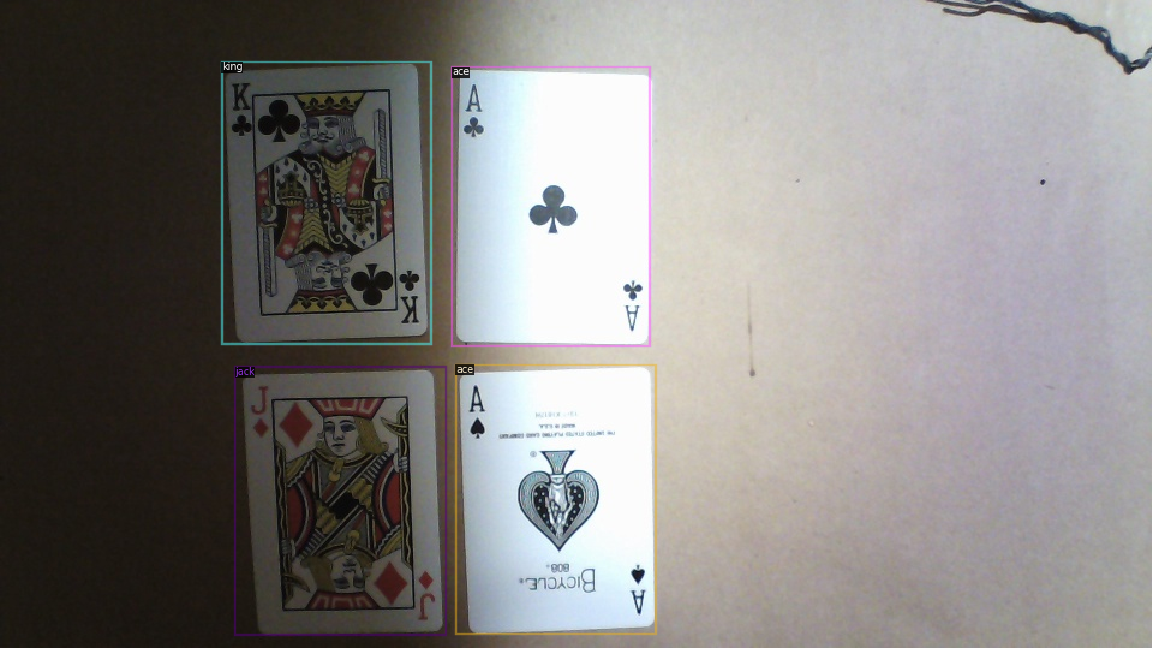

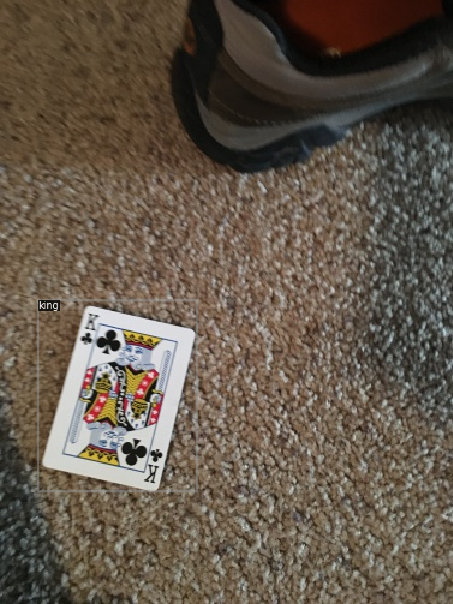

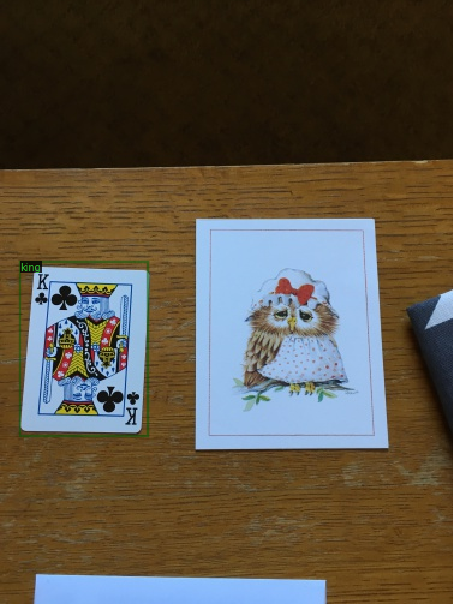

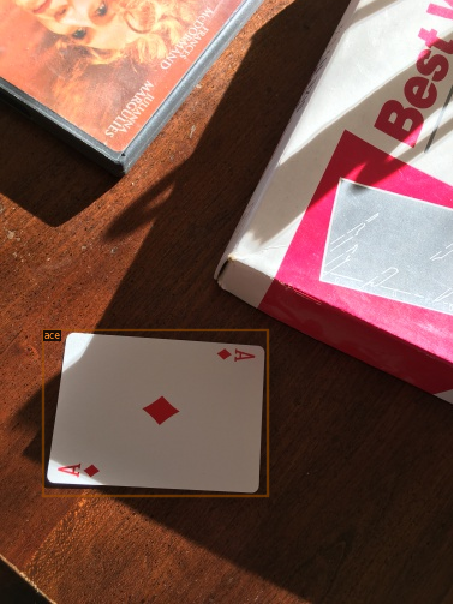

In [5]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=1.2)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [7]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("customtrain",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 700    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
import os

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[10/31 10:44:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:09, 18.3MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[10/31 10:44:20 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[10/31 10:44:45 d2.utils.events]:  eta: 0:12:54  iter: 19  total_loss: 2.545  loss_cls: 1.82  loss_box_reg: 0.731  loss_rpn_cls: 0.005488  loss_rpn_loc: 0.005354  time: 1.1769  data_time: 0.0300  lr: 7.0289e-05  max_mem: 2804M
[10/31 10:45:07 d2.utils.events]:  eta: 0:12:12  iter: 39  total_loss: 1.621  loss_cls: 0.8392  loss_box_reg: 0.7239  loss_rpn_cls: 0.005805  loss_rpn_loc: 0.005375  time: 1.1514  data_time: 0.0071  lr: 0.00014165  max_mem: 2804M
[10/31 10:45:30 d2.utils.events]:  eta: 0:11:47  iter: 59  total_loss: 1.288  loss_cls: 0.554  loss_box_reg: 0.7264  loss_rpn_cls: 0.002214  loss_rpn_loc: 0.002758  time: 1.1412  data_time: 0.0072  lr: 0.000213  max_mem: 2804M
[10/31 10:45:52 d2.utils.events]:  eta: 0:11:28  iter: 79  total_loss: 1.248  loss_cls: 0.5093  loss_box_reg: 0.7217  loss_rpn_cls: 0.00107  loss_rpn_loc: 0.002647  time: 1.1371  data_time: 0.0072  lr: 0.00028436  max_mem: 2804M
[10/31 10:46:15 d2.utils.events]:  eta: 0:11:07  iter: 99  total_loss: 1.181  loss_cls:

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("customtrain", )
predictor = DefaultPredictor(cfg)

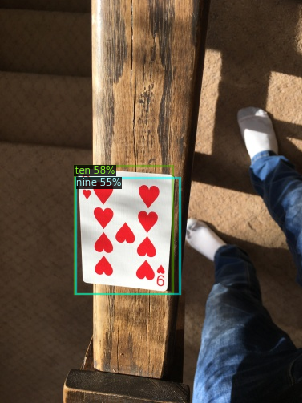

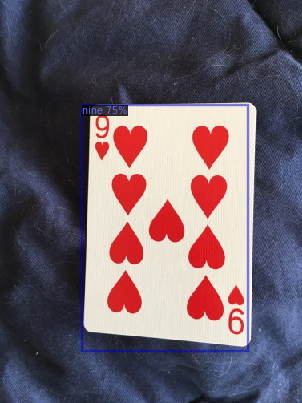

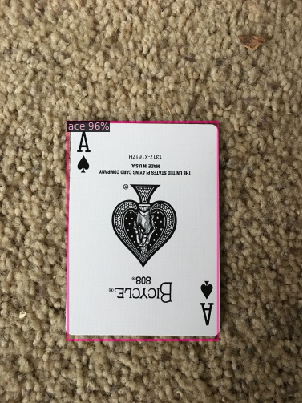

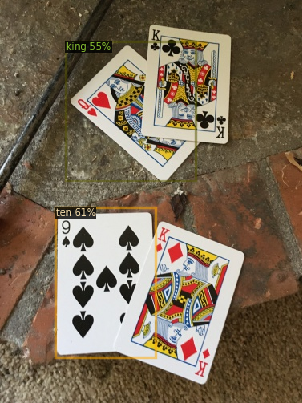

In [9]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [10]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()